# A look at the world wine market

In this article we want to have a look at present wine market prices and geographic distribution from the point of view of the Wine.com website. **MORE**

The Data Journalism technical topics we will cover in this article notebook include:  

- How to retrieve data from a web API, the [Wine.com Developer API](https://api.wine.com/) in our case.
- How to work with JSON formatted data, including:
 - How to get it from a HTTP requestresult into Python data structures.
 - How to write into a text file.
 - How to read it back.
 - How to put it into a Pandas data frame.
- How to perform data aggregations on our data in order to calculate statistics by appellation.
- How to generate interactive visualisations from the previous results.

Hopefully you will find this article interesting but, overall, you will learn the techniques we use here in order to apply them to your own data journalism projects. And hey, maybe after that you will be a bit more wine knowledgeable and a better buyer!

## Getting Wine.com API data

In this notebook we will use [Wine.com Developer API](https://api.wine.com/) in order to get a catalog of products we can later use for different analysis. We will use Python's library [Requests](http://www.python-requests.org/en/latest/) to retrieve the data in json format. Then we will store that data in a file for later use.

### Loading API key

First of all you need to sign up for a Wine.com developer account. Once you are registered, go to your Dashboard and copy your API key into a file called `apikey` that we can read using the following Python code.

In [1]:
apikey_f = open('apikey','r')
apikey = apikey_f.readline().replace('\n', ' ').replace('\r', '').replace(' ', '')

In [2]:
print apikey

45e24313426662fc6b8ab832d9140a16


### Making API requests

The goal of the Wine.com Developer API is to provide developers access to their extensive catalog of wine and wine related content in an open and easy to use manner. The API is built using [REST principles](https://en.wikipedia.org/wiki/Representational_state_transfer). You can retrieve content in either XML or JSON format. The best way to start is by having a look at [their documentation](https://api.wine.com/wiki) to read how the API works and the conditions of use.

From there we can learn that the base URL for any catalog query is as follows.

In [3]:
base_catalog_url = "http://services.wine.com/api/beta2/service.svc/json/catalog"

This base URL will be followed by a series of parameters and our API key in order to perform an actual query.

One of the best ways to query a web API is to use the Python library [Requests](http://www.python-requests.org/en/latest/). In the words of its developers *"Python’s standard [urllib2](https://docs.python.org/2/library/urllib2.html) module provides most of the HTTP capabilities you need, but the API is thoroughly broken. It was built for a different time — and a different web. It requires an enormous amount of work (even method overrides) to perform the simplest of tasks"*. Let's start by importing the library (it might need [installation](http://docs.python-requests.org/en/latest/user/install/)).

In [4]:
import requests

#### Getting the total number of wines in the catalog

The goal of our first query is to find out how many products does the catalog have in total. Since we are using Python [Requests](http://www.python-requests.org/en/latest/), the best way to prepare queries is by using the base URL with a Python dictionary of parameters. For example, the following dictionary will ask for zero products, but still the API will give as the total of products as part of the response.

In [5]:
zero_query_params = {
    'filter': 'categories(490)',
    'apikey': apikey,
    'size': 0,
    'offset': 0
}

Using Requests to [pass request parameters](http://www.python-requests.org/en/latest/user/quickstart/#passing-parameters-in-urls) is super easy. Just call `requests.get` passing the base URL and the previous dictionary. We call `json` on the result so we get the json result into a Python dictionary.

In [6]:
zero_request_json = requests.get(base_catalog_url, params=zero_query_params).json()

In [7]:
zero_request_json

{u'Products': {u'List': [], u'Offset': 0, u'Total': 85142, u'Url': u''},
 u'Status': {u'Messages': [], u'ReturnCode': 0}}

There we have an empty list of products and the total we are looking for.

In [8]:
total_wines = zero_request_json['Products']['Total']
total_wines

85142

#### Getting the actual products

We can proceed now to get actual products from the catalog. With a [Wine.com Developer account](https://api.wine.com/), we are limited to 1000 hits per day. Therefore we have to manage to get the list of products we want in just 1000 hits. We have more than 85K products in total. Then we need to get at least 86 products per hit if we want to get all of them. Let's define then a page size of 500 so we spend just 171 of our requests. Let's also wait 10 seconds between requests, so we don't overload the server.

In [9]:
# Don't make this too small. Be respectful!
inter_request_lapse = 10

# Total products to be requested
max_wines = total_wines # If you don't want all wines, use something smaller like 5000

# Max. products by request
page_size = 500

We are now ready to get our products using the Wine.com API as follows.

In [10]:
import time

offset = 0
wines_json = []

while (offset < max_wines):
    
    catalog_query_params = {
        'filter': 'categories(490)',
        'apikey': apikey,
        'size': page_size,
        'offset': offset
    }
    catalog_request_json = requests.get(base_catalog_url, params=catalog_query_params).json()
    wines_json.extend(catalog_request_json['Products']['List'])
    print "Read {} wines from Wine.com so far".format(len(wines_json))
    offset = offset + page_size
    time.sleep(inter_request_lapse)

Read 500 wines from Wine.com so far
Read 1000 wines from Wine.com so far
Read 1500 wines from Wine.com so far
Read 2000 wines from Wine.com so far
Read 2500 wines from Wine.com so far
Read 3000 wines from Wine.com so far
Read 3500 wines from Wine.com so far
Read 4000 wines from Wine.com so far
Read 4500 wines from Wine.com so far
Read 5000 wines from Wine.com so far
Read 5500 wines from Wine.com so far
Read 6000 wines from Wine.com so far
Read 6500 wines from Wine.com so far
Read 7000 wines from Wine.com so far
Read 7500 wines from Wine.com so far
Read 8000 wines from Wine.com so far
Read 8500 wines from Wine.com so far
Read 9000 wines from Wine.com so far
Read 9500 wines from Wine.com so far
Read 10000 wines from Wine.com so far
Read 10500 wines from Wine.com so far
Read 11000 wines from Wine.com so far
Read 11500 wines from Wine.com so far
Read 12000 wines from Wine.com so far
Read 12500 wines from Wine.com so far
Read 13000 wines from Wine.com so far
Read 13500 wines from Wine.com s

We ended up with a list of products, as they were given by the Wine.com Developer API. Let's check how many of them we have.

In [11]:
len(wines_json)

85142

### Writing JSON data into a file

One thing we want to do is to store the list of products in a text file so we can process the data without querying the Wine.com Developer API over and over again. We do this in Python as follows.

In [5]:
import json

In [16]:
with open("data_{}.json".format(max_wines), 'w') as outfile:
    json.dump(wines_json, outfile)

Let's read it back in order to check so we know how to do that later on when needed.

In [3]:
#max_wines = 85142 

In [6]:
with open("data_{}.json".format(max_wines),'r') as inputfile:
    new_data = json.load(inputfile)

In [7]:
len(new_data)

85142

## Loading wine data into a Pandas data frame

Let's have a look at what an product information looks like in json format.

In [10]:
new_data[10]

{u'Appellation': {u'Id': 2398,
  u'Name': u'Napa Valley',
  u'Region': {u'Area': None,
   u'Id': 101,
   u'Name': u'California',
   u'Url': u'http://www.wine.com/v6/California/wine/list.aspx?N=7155+101'},
  u'Url': u'http://www.wine.com/v6/Napa-Valley/wine/list.aspx?N=7155+101+2398'},
 u'Community': {u'Reviews': {u'HighestScore': 0,
   u'List': [],
   u'Url': u'http://www.wine.com/v6/Shafer-Hillside-Select-Cabernet-Sauvignon-2011/wine/146881/Detail.aspx?pageType=reviews'},
  u'Url': u'http://www.wine.com/v6/Shafer-Hillside-Select-Cabernet-Sauvignon-2011/wine/146881/Detail.aspx'},
 u'Description': u'',
 u'GeoLocation': {u'Latitude': -360,
  u'Longitude': -360,
  u'Url': u'http://www.wine.com/v6/aboutwine/mapof.aspx?winery=482'},
 u'Id': 146881,
 u'Labels': [{u'Id': u'146881m',
   u'Name': u'thumbnail',
   u'Url': u'http://cache.wine.com/labels/146881m.jpg'}],
 u'Name': u'Shafer Hillside Select Cabernet Sauvignon 2011',
 u'PriceMax': 269.0,
 u'PriceMin': 269.0,
 u'PriceRetail': 269.0,
 u

We have quite a lot of information there. Right now we will be interested in:  

- Wine name
- Appellation name
- Region name
- Varietal name
- Wine tpye (e.g. red wine, white wine, etc)
- Retail price

We can build a Pandas data frame from a dictionary of Python lists that will act as columns. This is just what we are going to do. We will create individual lists for each column by applying a different function to each element in our product list. We will use `map` for that, and the individual function will access the json field we want to include in the specific column.

Fro example, if we want a list with all the wine names, we can do as follows.

In [35]:
wine_names = map(lambda x: x['Name'], new_data)

That was easy cause every single product has a name. However, some columns will have values missing when a product will not include that information. In that case we need to deal with that situation as follows.

In [103]:
def get_appellation_or_empty(product):
    try:
        return product['Appellation']['Name']
    except:
        return ''
    
wine_appellations = map(get_appellation_or_empty, new_data)
wine_appellations[:5]

[u'Tuscany', u'Tuscany', u'Rioja', u'Napa Valley', u'Rioja']

That code tries to get a product appelattion name and if it fails it returns the empty string. Let's process the rest of the columns.

In [37]:
def get_region_or_empty(product):
    try:
        return product['Appellation']['Region']['Name']
    except:
        return ''

wine_regions = map(get_region_or_empty, new_data)
wine_regions[:5]

[u'Italy', u'Italy', u'Spain', u'California', u'Spain']

In [38]:
def get_varietal_or_empty(product):
    try:
        return product['Varietal']['Name']
    except:
        return ''
    
wine_varietals = map(get_varietal_or_empty, new_data)
wine_varietals[:5]

[u'Other Red Blends',
 u'Sangiovese',
 u'Tempranillo',
 u'Cabernet Sauvignon',
 u'Tempranillo']

In [39]:
def get_wine_type_or_empty(product):
    try:
        return product['Varietal']['WineType']['Name']
    except:
        return ''
    
wine_wine_types = map(get_wine_type_or_empty, new_data)
wine_wine_types[:5]

[u'Red Wines', u'Red Wines', u'Red Wines', u'Red Wines', u'Red Wines']

In [40]:
wine_retail_prices = map(lambda x: x['PriceRetail'], new_data)
wine_retail_prices[:5]

[99.0, 45.0, 65.0, 165.0, 38.0]

We have now all our column data ready. Let's create a Pandas data frame from it. First we need to create a dictionary defining our data.

In [104]:
wines_dict = {
    'Appellation': wine_appellations,
    'Region': wine_regions,
    'Name': wine_names,
    'Varietal': wine_varietals,
    'WineType': wine_wine_types,
    'RetailPrice': wine_retail_prices
}

And now we can use that dictionary to call the `DataFrame` constructor. We also pass the name of the columns that, although is not necessary if we want all of them, it defines the order we want for them and not the one given by the Python dictionary keys.

In [105]:
import pandas as pd

wines_df = pd.DataFrame(
    data=wines_dict, 
    columns=[
        'Region',
        'Appellation',
        'Name',
        'Varietal',
        'WineType',
        'RetailPrice'
    ]
)

Let's have a look at the first ten rows in our wines data frame.

In [106]:
wines_df.head(10)

,Region,Appellation,Name,Varietal,WineType,RetailPrice
0,Italy,Tuscany,Fattoria Le Pupille Elisabetta Geppetti 'Saffr...,Other Red Blends,Red Wines,99.00
1,Italy,Tuscany,Caparzo Brunello di Montalcino 2010,Sangiovese,Red Wines,45.00
2,Spain,Rioja,Bodegas Muga Gran Reserva Prado Enea 2006,Tempranillo,Red Wines,65.00
3,California,Napa Valley,Beringer Private Reserve Cabernet Sauvignon 2012,Cabernet Sauvignon,Red Wines,165.00
4,Spain,Rioja,Faustino I Gran Reserva 2001,Tempranillo,Red Wines,38.00
5,California,Napa Valley,CADE Estate Cabernet Sauvignon 2012,Cabernet Sauvignon,Red Wines,89.99
6,California,Napa Valley,Silver Oak Napa Valley Cabernet Sauvignon 2010,Cabernet Sauvignon,Red Wines,110.00
7,Italy,Tuscany,Casanova di Neri Brunello di Montalcino Tenuta...,Sangiovese,Red Wines,159.00
8,France - Other regions,Champagne,Veuve Clicquot Brut Yellow Label,Non-Vintage,Champagne & Sparkling,56.99
9,California,Napa Valley,Joseph Phelps Insignia 2012,Cabernet Sauvignon,Red Wines,225.00


And I think we are ready to start our analysis.

## Exploring wine prices

It's always a good idea to start an exploratory data analysis by calling the handy `describe` method on our data frame.

In [107]:
wines_df.describe()

,RetailPrice
count,85142.000000
mean,52.441124
std,173.100791
min,0.000000
25%,15.000000
50%,22.990000
75%,44.990000
max,12819.000000


We have just one numerical variable, retail price. There we can see summary statistics accross all the dataset. For example, the average wine price is around `$`52 (with a standard deviation of `$`173), with an astronomic higuest price of more than `$`12,000 and some wines given for free at `$`0. However the median price is around `$`23. This makes more sense. It looks like the average price in my own cellar actually. We know the median is less affected by a distribution edges. The first and third quartiles make sense as well, being `$`15 and `$`45.

### Exploring regions

Let's know explore the previous variables by wine region. The first thing we have to do is aggregate our data frame by the `Region` column. We can do this very easily in Python/Pandas as follows.

In [108]:
wines_by_region_df = wines_df.groupby(['Region'])

In [109]:
wines_by_region_df

The previous gives us a `DataFrameGroupBy` object we can use for getting statistics as we did with a normal data frame. For example, let's get the median prices by region, and put them in a bar chart, sorted by price.

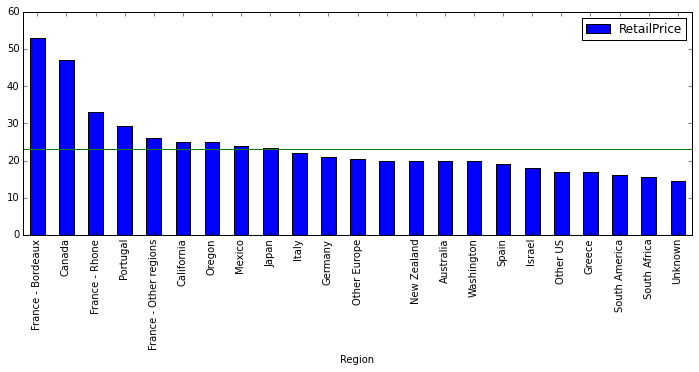

In [114]:
%matplotlib inline 

import matplotlib.pyplot as plt
plt.figure() 
wines_by_region_df.median().sort(['RetailPrice'],ascending=False).plot(figsize=(12,4), kind='bar')
plt.axhline(wines_df.RetailPrice.median(), color='g')

The green horizontal line is a reference for the median value for the whole dataset. We have some well known regions with median retail prices above the global median, such as Burdeux, the Rhone Valley, or California, but also some others not so well known like Canada (at least not so well known by its luxury wines). Actually Bordeaux is over the third quartile (i.e. `$`45) for the global distribution. These are countries we could consider to be expensive.

Then we have those regions below the median retail price. Some of them are well known for providing supermarket wines (not that this is something bad) such as Australia, South Africa, etc. although some of them are also part of the classic wine regions, such as Italy or Spain.

Remember that we are just looking at a fraction of the wine market given by a single website, so don't take this as the actual truth of the wine market. It is a shame we can't really use the rating information from Wine.com (at least with the Developer API we don't have individual ratings). That way we could have compared the median price with the median quality.

### Exploring appellations

We can have a more detailed look at the previous if we explore the retail price not just by region but by appellation. Remember that a given region can contain multiple appellations.

In [130]:
wines_by_appellation_df = wines_df.groupby(['Appellation','Region'])

In [ ]:
wine_by_appellation_median_sorted = wines_by_appellation_df.median().sort(
    ['RetailPrice']
)

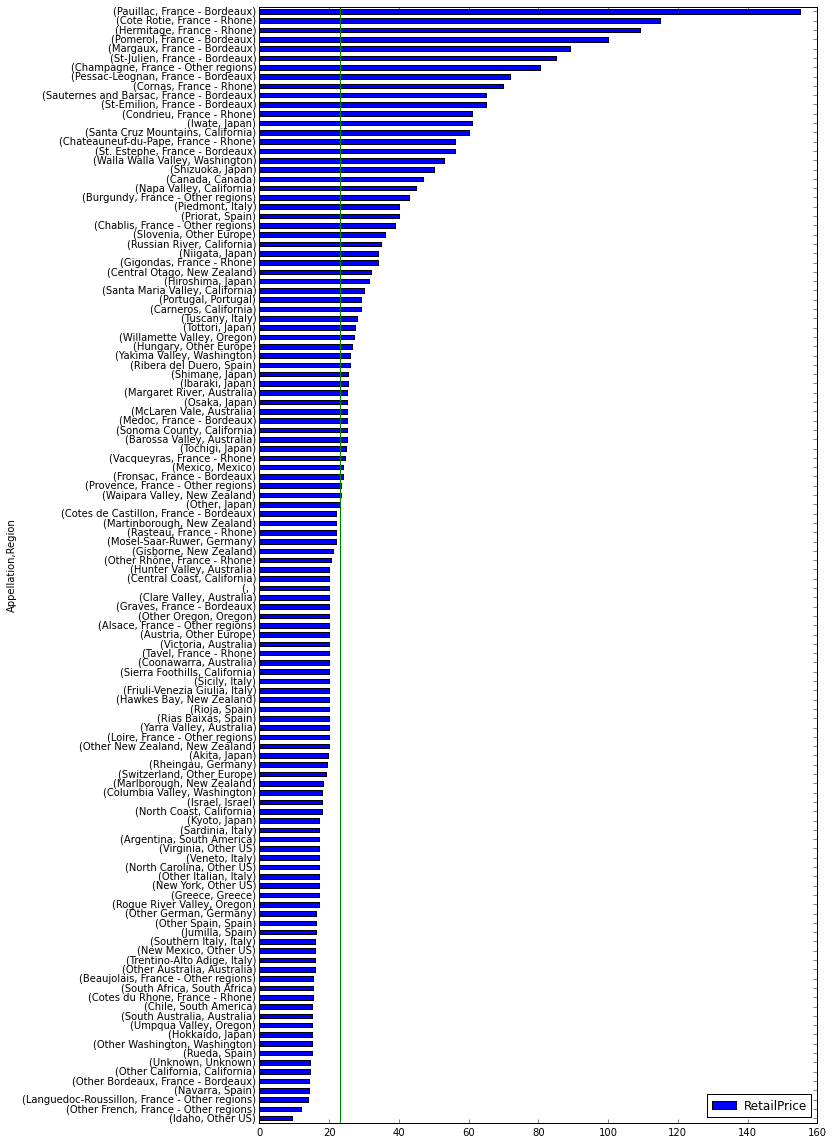

In [151]:
plt.figure() 
wine_by_appellation_median_sorted.plot(
    figsize=(10,20), 
    kind='barh'
)
plt.axvline(wines_df.RetailPrice.median(), color='g')

The appellations are consistent with what we saw for the regions. Most expensive appellations are in France for example. But here are some interesting facts that we didn't get with the regions chart:  

- The most expensive appellation regarding median retain price is *Paulillac* in *Bordeaux, France*.  
- the less expensive is *Idaho*.
- Some Bordeaux wines are quite below the median retail price (e.g. *Other Bordeaux* and even *Graves - Bordeaux* that is world know by its classy wines).  
- Burgundy ws actually under *Other Regions - France* and yes, it is very expensive.
- The most expensive appellation in the US regarding median retain price is not Napa Valley but Walla Walla Valley, in Washington.
- Regions not considered expensive in the previous chart have expensive appellations such as *Piedmont* or *Tuscany* in *Italy*, *Priorat* in *Spain*, or *Central Otago* in *New Zealand*.

### What about grapes?

Specially in the New World, people tend to think that wine is all about grape varieties than wine regions. So let's have a look at retail prices by grape varieties. We will proceed as we did before.

In [153]:
wines_by_varietal_df = wines_df.groupby(['Varietal'])

In [154]:
wine_by_varietal_median_sorted = wines_by_varietal_df.median().sort(
    ['RetailPrice']
)

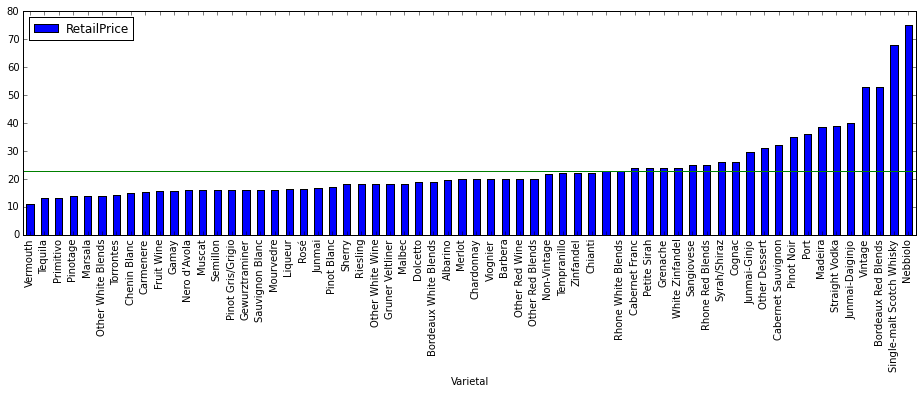

In [160]:
plt.figure() 
wine_by_varietal_median_sorted.plot(
    figsize=(16,4), 
    kind='bar'
)
plt.axhline(wines_df.RetailPrice.median(), color='g')

The first thing we notice is that we have not just wines in our dataset but also spirits (e.g. Single-malt Scotch Whisky).

But there is also something interesting happening here. Right now we are looking at our wines in a different classification that is not exactly geographical, and interesting things happen. For example, the varietal that makes the most expensive wines (regarding median retail price and Wine.com stats) is *Nebbiolo*. 

Does this make sense at all? Let's see. We know [Nebbiolo](https://en.wikipedia.org/wiki/Nebbiolo) is mainly used in *Piedmont*, in Italy. We already saw that is an expensive appellation. But if we pay attention to what we have seen so far, the most expensive grapes should be those used in Bordeaux, (e.g. Merlot, Cabernet, etc). So what happens? Very simple. The french varietals became so popular that they are used all around the world, for wines in all price ranges, while Nebbiolo has managed to stay quite local in Piedmont, producing amazing and rather expensive Barolos. Actually we can see that Merlot for example is quite affordable, and that Bordeaux Red Blends are quite high, but still below Nebbiolo since probably wines outside Bordeaux are using that specific blends.

### And finally, what about types of wine

Just in order to be complete in our analysis, let's have a look at median retain prices by wine type. 

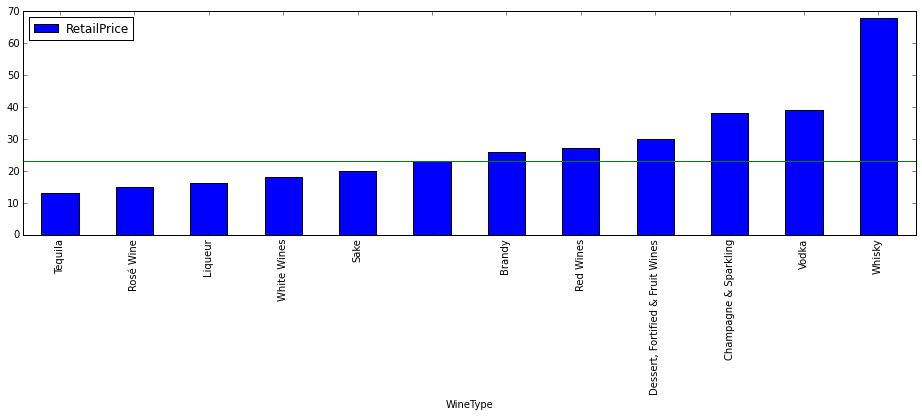

In [159]:
wines_by_type_df = wines_df.groupby(['WineType'])
wine_by_type_median_sorted = wines_by_type_df.median().sort(
    ['RetailPrice']
)
plt.figure() 
wine_by_type_median_sorted.plot(
    figsize=(16,4), 
    kind='bar'
)
plt.axhline(wines_df.RetailPrice.median(), color='g')

Well, there is the answer to your question. *Red Wines* are likely to be more expensive than *Whites Wines*, but not as much as *Champagne & Sparkling*. What comes as a surprise is that *Vodka* appears there... Probably we shouldn't take that data seriously. Why?

In [171]:
sum(wines_df.WineType=='Vodka')

2

Is is based in a single element. Actually let's have a look at the histogram.

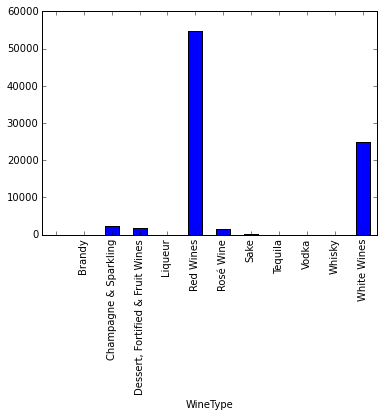

In [190]:
wines_by_type_df.count()['Name'].plot(kind='bar')

## A single visualisation using Bokeh

So far we have been doing exploratory data analysis. What we want to do in this section is to create a single visualisation that summarises many of the previous findings, something more interactive and engaging that can be seen in a modern web browser. For that purpose we will use some of the previous data frames and the Python library Bokeh.  

## Conclusions

Remember that we are just looking at a fraction of the wine market given by a single website, so don't take this as the actual truth of the wine market. It is a shame we can't really use the rating information from Wine.com (at least with the Developer API we don't have individual ratings). That way we could have compared the median price with the median quality.